# 03 - Interactive Viz

## Important
In order to see the rendered maps, you can follow this [link](https://nbviewer.jupyter.org/github/armand33/applied_data_analysis_2017/blob/master/03%20-%20Interactive%20Viz/Homework%203.ipynb?flush_cache=true) to an online notebook viewer.

If link is dead, and to make sure you read the latest version of render, you can also go on the [notebook viewer website](https://nbviewer.jupyter.org/) and paste the github [link](https://github.com/armand33/applied_data_analysis_2017/blob/master/03%20-%20Interactive%20Viz/Homework%203.ipynb) of our notebook.


In [1]:
import pandas as pd
import numpy as np
import branca.colormap as bcm
import folium
import json
import geopandas as gpd
import codecs
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm
from geopandas import GeoSeries, GeoDataFrame
from folium.plugins import MarkerCluster

### General choices:

In all this homework, we chose the rates over the last quarter (for Europe). For Switzerland, we downloaded the unemployment numbers for September 2017 to reproduce the numbers mentioned in the report. We could have averaged over the last calendar year (that would have canceled some eventual season effects) but it would also have taken into account outdated data. **We generally chose to work on the latest data available.**

# 1) European unemployment

Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

   Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

#### Paths

In [2]:
europe_csv = 'data/lfsq_urgan_1_Data.csv'
topo_path = r'topojson/europe.topojson.json'

In [3]:
topo_data = json.load(open(topo_path))

#### Extracting unemployment rates

We use the unemployement rates of the second quarter of 2017. These are the most recent rates found on the eurostat website.

In [4]:
df = pd.read_csv(europe_csv)
df = df.loc[df.TIME == '2017Q2'].loc[df.SEX == 'Total'].loc[:, ['GEO', 'Value']]
df.columns = ['country', 'rate']
df = df[6:].reset_index(drop=True)
df.head()

,country,rate
0,Belgium,7.0
1,Bulgaria,6.3
2,Czech Republic,3.0
3,Denmark,5.5
4,Germany (until 1990 former territory of the FRG),3.8


Changing some names to simplify later displying and merging.

In [5]:
df.loc[df.country == 'Germany (until 1990 former territory of the FRG)', 'country'] = 'Germany'
df.loc[df.country == 'Former Yugoslav Republic of Macedonia, the', 'country'] = 'The former Yugoslav Republic of Macedonia'

#### Retrieving the two-letter country codes for each country. 

These codes are contained in the topojson file provided. They will be useful in order to build the map.

In [6]:
countries = {}
for d in topo_data['objects']['europe']['geometries']:
    countries[d['properties']['NAME']] = d['id']

#### Entering those codes in the dataframe

In [7]:
for i in df.index:
    df.loc[i, 'code'] = countries[df.loc[i, 'country']]

In [8]:
df = df.sort_values('rate').reset_index(drop=True)
df.head()

,country,rate,code
0,Czech Republic,3.0,CZ
1,Iceland,3.4,IS
2,Germany,3.8,DE
3,Malta,4.1,MT
4,United Kingdom,4.3,GB


#### Choosing intervals for colors :

We use 5 classes:
* 1 for outliers (Spaine, Greece and Macedonia)
* 4 for the other countries using quantile classification 

In [9]:
df.loc[:len(df)-3, 'class'] = pd.qcut(df.rate[:len(df)-3], 4, labels = [i for i in range(1,5)])
df.loc[len(df)-3:, 'class'] = 5

Here is the number of countries for which the unemployment rate is in each interval.

In [10]:
df['class'].value_counts()

4.0    8
1.0    8
3.0    7
2.0    7
5.0    3
Name: class, dtype: int64

The interval bounds are the following:

In [11]:
t = [min(df['rate'])]
for i in range(1,6):
    tmp = df.loc[df['class'] == i]['rate'].values
    t.append(max(tmp))
    
t

[3.0,
 4.4000000000000004,
 6.2999999999999998,
 8.0999999999999996,
 11.0,
 22.600000000000001]

#### Building the map

#### Chloropleth

We add a cholorpleth for the present data. First, we define a meaningful colormap:

We will show the colormap in quantiles according to the rates, in order to account show more differences in the values:

In [12]:
cm1 = bcm.linear.YlOrRd

cm1 = cm1.to_step(index=t)

cm1.caption = 'Unemployment rate [%]'
cm1

**Yellow** indicates good (low) worklessness rates, **Red** indicates bad (high) worklessness rates. Missing countries in the Eurostat statistics will be colored **black**.

In [13]:
def my_color_function(feature, field, cm):
    """Maps low values to green and hugh values to red."""

    rate = df[df['code'] == feature['id']][field]
    if len(rate)>0: # check if the country is in the dataframe
        rate = float(np.asarray(df[df['code'] == feature['id']][field])
)
        return cm(rate)
    else:
        return '#f000000'

In [14]:
m1 = folium.Map(location=[50, 10], zoom_start=4, tiles='cartodbpositron')

folium.TopoJson(
    topo_data,
    'objects.europe',
    name='topojson',
    style_function=lambda feature: {
        'fillColor': my_color_function(feature,'rate', cm1),
        'fillOpacity':.7,
        'color' : 'black',
        'weight' : .7,
        'dashArray' : '2, 2'
        }
).add_to(m1)
m1.add_child(cm1)
% clear # avoid printing output

#### Adding interactivity

We want to add some markers on each country in order to get the exact value of unemployement rate by clicking on it.
To do that we use a data set called `country_centroids_primary` that provides the coordinates of centroids of countries. This data set comes from [Gotos]('http://gothos.info/resources/').

In [15]:
centro = pd.read_csv('data/country_centroids_primary.csv', sep=('\t')).loc[:, ['LAT', 'LONG', 'SHORT_NAME']]
centro.columns = ['lat', 'long', 'name']
centro.head()

,lat,long,name
0,33.000000,66.0,Afghanistan
1,41.000000,20.0,Albania
2,28.000000,3.0,Algeria
3,-14.333333,-170.0,American Samoa
4,42.500000,1.5,Andorra


Now for each country of europe, we add the marker on the centroid. By clicking on the marker, one get the required value.

In [16]:
m_c = MarkerCluster().add_to(m1)

for i in df.index:
    n = df.loc[i, 'country']
    p = df.loc[i, 'rate']
    if n == 'The former Yugoslav Republic of Macedonia':
        n = 'Macedonia'
    long, lat = centro.loc[centro.name == n, 'long'].values[0], centro.loc[centro.name == n, 'lat'].values[0]
    folium.Marker([lat, long], popup='{} : {}%'.format(n, p) , icon=folium.Icon(color='green')).add_to(m_c)

In [17]:
m1.save('maps/m1.html')
m1

This is the final map. Black countries are countries for which there is no data.

#### Comparing to the rate in Switzerland

We choose to plot countries that have lower unemployement rates in purple to blue and others on the same color scale as before (Yellow-Orange-Red).

In [18]:
df['diff'] = df['rate'] - df.loc[df.country == 'Switzerland', 'rate'].values
df['diff'] = df['diff'].astype(float).round(1)

### Map Difference CH - Europe
This time we want to build a "bi-polar" chloropleth to show two sides: positive (green) = countries with lower or similar unemployment rates, negative (red) = countries with higher unemployment rates.

In [19]:
cm11 = bcm.LinearColormap(['green', 'white','red'], vmin=np.min(df['diff']),vmax=np.max(df['diff']),
                          index=[np.min(df['diff']),0,np.max(df['diff'])])

In [20]:
cm11

In [21]:
m11 = folium.Map(location=[50, 10], zoom_start=4, tiles='cartodbpositron')

folium.TopoJson(
    topo_data,
    'objects.europe',
    name='topojson',
    style_function=lambda feature: {
        'fillColor': my_color_function(feature, 'diff',cm11),
        'fillOpacity':.7,
        'color' : 'black',
        'weight' : .7,
        'dashArray' : '2, 2'
        }
).add_to(m11)
m11.add_child(cm11)

# Adding the markers
m_c = MarkerCluster().add_to(m11)

for i in df.index:
    n = df.loc[i, 'country']
    p = df.loc[i, 'diff']
    if n == 'The former Yugoslav Republic of Macedonia':
        n = 'Macedonia'
    long, lat = centro.loc[centro.name == n, 'long'].values[0], centro.loc[centro.name == n, 'lat'].values[0]
    folium.Marker([lat, long], popup='{} : {}%'.format(n, p) , icon=folium.Icon(color='green')).add_to(m_c)
    

m11.save('maps/m11.html')
m11

Note that Norway is still in white as it has the same rate as Switzerland.

We note that most of countries in Europe have higher unemployement rate that swizerland.

Countries that are really different from Switzerland are darker than others (Norway is in white as noted above).

# 2) Suisse

Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

   Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

   The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

   Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

#### The assumptions

- When we import the data the unemployement rate that we get in the beginning is equals to the way the Swiss Confederation defines unemloyement
- We retrieve our data from the amstat website under '2.1 Arbeitlosenquoten' 
- The unemployement period we pick is of year 2017 September
- We choose the german version of the data due to the fact that the topojson file has most of the country names in german. Therefore, we need the codes of these countries.
- In the amstat website, unemployement is defined by the number of registered unemployed divided by the number of active people. Therefore, the way this questions defines unemployement is false. See the FAQ https://www.amstat.ch/v2/faq.jsp?lang=fr
- By this definition, we will categorize by plotting the rate of unemployed jobseekers, the rate of employed, and the rate of jobseekers per canton in Switzerland



#### Data loading and cleaning

In [22]:
#Read the data
df = pd.read_excel('data/unemployment.xlsx')

# drop useless columns
df = df.drop(['Gesamt','Gesamt.1','Gesamt.2','Gesamt.3'],axis = 1)

# drop first and last rows
df = df.drop(df.index[0])
df = df.drop(df.index[len(df)-1])

# rename the columns 
df.columns = ['canton','Rate','Registered unemployed','Registered jobseeker','Registered non-unemployed jobseeker']

df = df.reset_index(drop=True)

We convert these respective columns which are of type string into numbers (float and int)

In [23]:
df['Rate'] = df['Rate'].astype(float)
df['Registered unemployed'] = df['Registered unemployed'].astype(int)
df['Registered jobseeker'] =  df['Registered jobseeker'].astype(int)
df['Registered non-unemployed jobseeker'] = df['Registered non-unemployed jobseeker'].astype(int)

In [24]:
#Cleaned data
df.head()

,canton,Rate,Registered unemployed,Registered jobseeker,Registered non-unemployed jobseeker
0,Aargau,2.9,10684,15145,4461
1,Appenzell Ausserrhoden,1.7,523,866,343
2,Appenzell Innerrhoden,0.7,62,102,40
3,Basel-Landschaft,2.8,4082,5540,1458
4,Basel-Stadt,3.5,3455,5168,1713


#### TopoJson setup

Now we want to attach the codes of each canton to our dataframe. Given a topojson file, we traverse this datastructure each time retrieving the canton and its code.

However we must state that there are some incoherences with the names of cantons in the topojson file and our read data from amstat. We solve these incoherences by choosing a common name between the 2 datasets.

In [25]:
# load topo json file
canton_geo_path = r'./topojson/ch-cantons.topojson.json'
with codecs.open(canton_geo_path, "r", encoding='utf-8', errors='ignore') as topo_data:
    topo_data = json.load(topo_data)

In [26]:
#we create a dictionary which has as a keys the cities and as values the codes 
canton_code = dict([(cantons['properties']['name'],cantons['id']) for cantons in topo_data['objects']['cantons']['geometries'] ])
    
#name incoherencies
old_code = ['Bern/Berne', 'Fribourg', 'Genève', 'Graubünden/Grigioni', 'Neuchâtel', 'Ticino', 'Valais/Wallis', 'Vaud']
new_code = ['Bern', 'Freiburg', 'Genf', 'Graubünden', 'Neuenburg', 'Tessin', 'Wallis', 'Waadt']

#we rename the old_code with the new code
for (old, new) in zip(old_code, new_code) :
    canton_code[new] = canton_code.pop(old)

We now finally combine the area codes with the our dataframe

In [27]:
codes = pd.Series(canton_code).reset_index().drop('index',axis = 1)
codes.columns= ['code']
df['code'] = codes

In [28]:
df.head()

,canton,Rate,Registered unemployed,Registered jobseeker,Registered non-unemployed jobseeker,code
0,Aargau,2.9,10684,15145,4461,AG
1,Appenzell Ausserrhoden,1.7,523,866,343,AR
2,Appenzell Innerrhoden,0.7,62,102,40,AI
3,Basel-Landschaft,2.8,4082,5540,1458,BL
4,Basel-Stadt,3.5,3455,5168,1713,BS


#### Display the data on a map

Let's build a chloropeth map displaying the unemployment rates of the cantons in Switzerland. Each canton will have a marker indicating its unemployement rate. 
The map is of course interactable

In [29]:
def makemap(topo_data, df, field, coordinates=[46.801111, 8.226667], legend='Unemployment rate (%)', t_min = None, t_max = None): 
    """
    This function is meant to build a cholorpleth.
    
    topo_data = data from the TopoJson file
    df = pandas DataFrame containing the rates
    field = field of df we which to display on the cholorpleth
    coordinates = in order to center the map
    legend = title of the legend
    """

    
    # get the range of the values
    if t_min is None and t_max is None:
        t_min = np.min(df[field].values.min())
        t_max = np.max(df[field].values.max())
    
    # intervals for the cholorpleth (by default we choose 6 intervals)
    t = list(np.linspace(t_min, t_max, 6))
     
    # create map
    m = folium.Map(location=coordinates, zoom_start=8, tiles='cartodbpositron')
    m.choropleth(geo_data=topo_data, data=df,
                 columns=['code', field], topojson='objects.cantons',
                 key_on='feature.id',
                 fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
                 legend_name=legend, threshold_scale = t, name='unemployment layer',highlight=True)

    # add markers
    m_c = MarkerCluster().add_to(m)
    for i in df.index:
        n = df.loc[i, 'canton']
        p = df.loc[i, field]
        long, lat = df.loc[df.canton == n, 'lon'].values[0], df.loc[df.canton == n, 'lat'].values[0]
        folium.Marker([lat, long], popup='{} : {}%'.format(n, p) , icon=folium.Icon(color='green')).add_to(m_c)
    return m

#### Obtain centroids for cantons
- Municipality data are obtained on the [OpenData](https://opendata.swiss/en/dataset/gemeindetypologie-are) platform, which provides a link to official data of the Confederation on commune boarders. They contain a field KT_KZ which is the code of the canton (Kanton-Kennzeichen). We need to dissolve this shapefile to obtain geometries for each canton.
- [Stackoverflow thread for dissolving geometries](https://gis.stackexchange.com/questions/149959/dissolving-polygons-based-on-attributes-with-python-shapely-fiona)
- Finally, we obtain the centroids by using the geopandas library, which allows getting the centroid of Shapefile geometries.

In [30]:
def dissolve_geometries():
    # define your directories and file names
    name_in = 'data/ARE_GemTyp00_9.shp'
    name_out = 'data/cantons_dissolved.shp'

    # create a dictionary
    states = {}
    # open your file with geopandas
    counties = GeoDataFrame.from_file(name_in, crs = {'init' :'epsg:21781'})
    for i in range(len(counties)):
        state_id = counties.at[i, 'KT_KZ']
        county_geometry = counties.at[i, 'geometry']
        # if the feature's state doesn't yet exist, create it and assign a list
        if state_id not in states:
            states[state_id] = []
        # append the feature to the list of features
        states[state_id].append(county_geometry)

    # create a geopandas geodataframe, with columns for state and geometry
    states_dissolved = GeoDataFrame(columns=['state', 'geometry'], crs=counties.crs)
    # iterate your dictionary
    for state, county_list in states.items():
        # create a geoseries from the list of features
        geometry = GeoSeries(county_list)
        # use unary_union to join them, thus returning polygon or multi-polygon
        geometry = geometry.unary_union
        # set your state and geometry values
        states_dissolved.set_value(state, 'state', state)
        states_dissolved.set_value(state, 'geometry', geometry)

    # save to file
    states_dissolved.to_file(name_out, driver="ESRI Shapefile")
    return states_dissolved

In [31]:
states_dissolved = dissolve_geometries()

We now inverse the `canton_code` dictionnary to retrieve the names of cantons in the disolved centroids list.

In [32]:
#Reverse canton code dictionary previously defined
reversed_cantons_code = {v: k for k, v in canton_code.items()}

Now we extract the coordinates of the centroid of each canton.

In [33]:
# Each value of this dictionnary is a Point object. Attributes x and y are its coordinates.
gdf = states_dissolved.centroid.to_crs({'init': 'epsg:4326'})

# retrieving x values
x = np.asarray(gdf.centroid.map(lambda p: p.x))
# retrieving y values
y = np.asarray(gdf.centroid.map(lambda p: p.y))

# array of the canton codes
cantons_c = np.array(states_dissolved['state'])

#we build our centroid datastructure
centroids = []
for i in range(len(cantons_c)):
    centroids.append([x[i],y[i], cantons_c[i], reversed_cantons_code[cantons_c[i]]])
    
# build a DataFrame
canton_centroids = pd.DataFrame(centroids,columns=['lon', 'lat', 'code', 'canton'])
canton_centroids = canton_centroids.sort_values('canton').reset_index(drop=True)
canton_centroids.head()

,lon,lat,code,canton
0,8.156634,47.410525,AG,Aargau
1,9.368506,47.366144,AR,Appenzell Ausserrhoden
2,9.416338,47.317171,AI,Appenzell Innerrhoden
3,7.702226,47.451729,BL,Basel-Landschaft
4,7.615262,47.564895,BS,Basel-Stadt


#### Merging centroid coordinates in global data frame

In [34]:
df = pd.merge(df, canton_centroids)

In [35]:
df.head()

,canton,Rate,Registered unemployed,Registered jobseeker,Registered non-unemployed jobseeker,code,lon,lat
0,Aargau,2.9,10684,15145,4461,AG,8.156634,47.410525
1,Appenzell Ausserrhoden,1.7,523,866,343,AR,9.368506,47.366144
2,Appenzell Innerrhoden,0.7,62,102,40,AI,9.416338,47.317171
3,Basel-Landschaft,2.8,4082,5540,1458,BL,7.702226,47.451729
4,Basel-Stadt,3.5,3455,5168,1713,BS,7.615262,47.564895


### We plot the map

In [36]:
swiss_coordinates = [46.801111, 8.226667]

Here we display the chlorpeth map of the unemployments per swiss cantons

In [37]:
m2 = makemap(topo_data, df, 'Rate', swiss_coordinates, 'Swiss confederation unemployment rates')
m2.save('maps/m2.html')
m2


We can see that Geneva has the highest employment rate (5.2%), while Uri has least unemployment rate of 0.6%. This is quite strange because, one would think that there more people there are in a canton the more likely the unemployment rate will increase. But this doesn't seem to be the case because for example Zurich's population is greater than Geneva's but the employment rate is lesser.

Here we derive formulas to calculate the number of active people, the rate of jobseekers, the rate of unemployed jobseekrs and the rate of employed jobseekers.

- $rate=\frac{N_{registered\_unemployed}}{N_{active\_people}} \times 100 \implies N_{active\_people}=\frac{N_{registered\_unemployed} \times 100}{rate}$
- $jobseekers (\%) = \frac{N_{jobseekers}}{N_{active\_people}} \times 100 $ 
- $unemployed\_jobseekers(\%) = \frac{N_{registered\_unemployed}}{N_{jobseekers}} \times jobseekers(\%)$
- $employed\_jobseekers(\%) = (jobseekers(\%) - unemployed\_jobseekers(\%)) $

This function takes the data frame in argument and returns another dataframe containing the number of active people, the rate of jobseekers, the rate of unemployed jobseekers and the rate of employed jobseekers.

In [38]:
def stats_on_different_category(df):
    """
    Function that computes 
    """
    data = df.copy()
    # compute rate corresponding to category (either registered unemployed and registered non_unemployed)
    data['Active people'] =  ((data['Registered unemployed'] * 100)/data['Rate'])
    data['Jobseekers (%)'] = (data['Registered jobseeker']/data['Active people']) * 100
    data['Unemployed Jobseekers (%)'] = (data['Registered unemployed']/data['Registered jobseeker']) * data['Jobseekers (%)']
    # drop other columns
    data['Employed Jobseekers(%)'] = data['Jobseekers (%)'] - data['Unemployed Jobseekers (%)']
    
    #We round these values to have a nice output
    data['Active people'] =  (data['Active people']).round(2)
    data['Jobseekers (%)'] = (data['Jobseekers (%)']).round(2)
    data['Unemployed Jobseekers (%)'] = (data['Unemployed Jobseekers (%)']).round(2)
    data['Employed Jobseekers(%)'] = (data['Employed Jobseekers(%)']).round(2)
    

    
    # return data frame with just interresting values
    return data

In [39]:
df = stats_on_different_category(df)

In [40]:
df.head()

,canton,Rate,Registered unemployed,Registered jobseeker,Registered non-unemployed jobseeker,code,lon,lat,Active people,Jobseekers (%),Unemployed Jobseekers (%),Employed Jobseekers(%)
0,Aargau,2.9,10684,15145,4461,AG,8.156634,47.410525,368413.79,4.11,2.9,1.21
1,Appenzell Ausserrhoden,1.7,523,866,343,AR,9.368506,47.366144,30764.71,2.81,1.7,1.11
2,Appenzell Innerrhoden,0.7,62,102,40,AI,9.416338,47.317171,8857.14,1.15,0.7,0.45
3,Basel-Landschaft,2.8,4082,5540,1458,BL,7.702226,47.451729,145785.71,3.80,2.8,1.00
4,Basel-Stadt,3.5,3455,5168,1713,BS,7.615262,47.564895,98714.29,5.24,3.5,1.74


#### Same scale

In order to build the maps of the jobseekers for both umemployed  and employed, we will use the same color scale. It will make it easier to compare.

In [41]:

t_min = min(df['Unemployed Jobseekers (%)'].values.min(), df['Employed Jobseekers(%)'].values.min())
t_max = max(df['Unemployed Jobseekers (%)'].values.max(), df['Employed Jobseekers(%)'].values.max())

#### Registered Unemployed jobseekers category

In this section, we only take into account the people who are unemployed  jobseekers. Since these values are the ones which represents the definition of unemployement.  

We plot the registered unemployed jobseekers

In [42]:
m3 = makemap(topo_data, df, 'Unemployed Jobseekers (%)', swiss_coordinates, 'Rate of unemployed jobseekers(%)', 
        t_min=t_min, t_max=t_max)
m3.save('maps/m3.html')
m3

#### Registered non-unemployed jobseekers 
Finally we only visualize the number of non-unemployed jobseekers. Basically these are people who aren't unemployed but they seek a new job.


In [43]:
m4 = makemap(topo_data,df, 'Employed Jobseekers(%)', swiss_coordinates, 'Rate for non-unemployed jobseekers (%)',
       t_min, t_max)
m4.save('maps/m4.html')
m4

Comparing these 2 maps, we can see that, of course that in general, there are more people who are unemployed jobseekers than there are employed jobseekers

#### Total Jobseekers Rate

We now would like to see which canton has the most jobseekers. This time we don't distinguish between being unemployed or not

In [44]:
t_min = np.min(df['Jobseekers (%)'])
t_max = np.max(df['Jobseekers (%)'])

In [45]:

m5 = makemap(topo_data,df, 'Jobseekers (%)', swiss_coordinates, 'Rate for all jobseekers (%)',
       t_min, t_max)
m5.save('maps/m5.html')
m5

This map is actually nice to analyze but one would think that Geneva would be the one who has the most jobseekers considering their unemployment rate. In the contrary, this is not the case
for Neuenburg which has the largest amount of jobseekers with 6.8%. 

# 3) Swiss and foreign workers

_Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers._

_The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers._

_Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better?). Where are the differences most visible ? Why do you think that is ?_

_Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data._

#### Assumptions
- We download the website from the category "2.1 Arbeitslosenquote (worklessness rates)".
- We select data for September 2017, the month in which the latest SECO employment market report was released, to try to reproduce and validate their numbers as closely as possible.
- First, we have to do some cleanup, which is done below. The final dataframe will have a column per canton, two columns for worklessness rates in percentage per nationality (Swiss / foreigner), and two columns for the absolute number of registered worklessness people (Swiss / foreigners).

### Data Preparation

#### Data Import and Cleaning

First, we import and preprocess the downloaded data.

In [46]:
worklessness_data = 'data/worklessness_ch_for_2017_09.xlsx'
df_for = pd.read_excel(worklessness_data)
df_for.head()

,Kanton,Nationalität,Monat,September 2017,September 2017.1,September 2017.2,Gesamt,Gesamt.1,Gesamt.2
0,NaN,NaN,Metriken,Arbeitslosenquote,Variationskoeffizient,Registrierte Arbeitslose,Arbeitslosenquote,Variationskoeffizient,Registrierte Arbeitslose
1,Zürich,Ausländer,NaN,5.3,A,12111,5.3,A,12111
2,Zürich,Schweizer,NaN,2.5,A,15114,2.5,A,15114
3,Bern,Ausländer,NaN,5.5,A,4900,5.5,A,4900
4,Bern,Schweizer,NaN,1.8,A,8758,1.8,A,8758


There are some data on canton, nationality, month (`NaN`), worklessness quote and number as well as a category, which we will not consider. First, we rearrange the data in a new dataframe, saving worklessness quotes and numbers for foreigners and Swiss people in separate columns.

Let's note that the total `Gesamt` is not differenciated according to the nationality.

In [47]:
# delete first row
df_for = df_for.drop(df_for.index[0]) 

df_for = df_for.sort_values(by="Kanton")
# delete duplicate / useless columns
df_for = df_for.drop(["Monat","Gesamt","Gesamt.1","Gesamt.2","September 2017.1"],axis=1)

# rename the columns
df_for.columns = (['canton', 'nationality', 'unemployment_rate', 'workless_registered'])


# casting columns to right type
df_for.workless_registered = df_for.workless_registered.astype(int)
df_for.unemployment_rate = df_for.unemployment_rate.astype(float)

df_for.head()

,canton,nationality,unemployment_rate,workless_registered
37,Aargau,Ausländer,5.6,4972
38,Aargau,Schweizer,2.1,5712
29,Appenzell Ausserrhoden,Ausländer,3.4,179
30,Appenzell Ausserrhoden,Schweizer,1.4,344
31,Appenzell Innerrhoden,Ausländer,2.0,23


In [48]:
# extracting unemployment rate for both Swiss citizens and foreigners
unemp_ch = np.asarray(df_for[df_for['nationality']=='Schweizer'].unemployment_rate)
unemp_for = np.asarray(df_for[df_for['nationality']=='Ausländer'].unemployment_rate)

# taking the difference in rates
diff_unemp_ch_for = unemp_for - unemp_ch

# extracting number of registered workless people for both Swiss citizens and foreigners
unemp_ch_reg = np.asarray(df_for[df_for['nationality'] == 'Schweizer'].workless_registered)
unemp_for_reg = np.asarray(df_for[df_for['nationality'] == 'Ausländer'].workless_registered)

# getting the list of cantons
cantons = list(np.unique(df_for[df_for.canton != 'Gesamt'].canton))

# put data in new, clean dataframe
df_for = pd.DataFrame({'canton':cantons,
                       'unemp_ch': unemp_ch,
                       'unemp_for': unemp_for,
                       'unemp_ch_reg': unemp_ch_reg,
                       'unemp_for_reg': unemp_for_reg,
                  'diff_unemp_ch_for': diff_unemp_ch_for})

df_for.head()

,canton,diff_unemp_ch_for,unemp_ch,unemp_ch_reg,unemp_for,unemp_for_reg
0,Aargau,3.5,2.1,5712,5.6,4972
1,Appenzell Ausserrhoden,2.0,1.4,344,3.4,179
2,Appenzell Innerrhoden,1.5,0.5,39,2.0,23
3,Basel-Landschaft,2.6,2.2,2486,4.8,1596
4,Basel-Stadt,1.8,2.8,1675,4.6,1780


The data above shows the relevant data extracted for September 2017: the name of the canton, the umemployment rate for Swiss people (`umemp_ch_reg`), foreigners (`unemp_for_reg`), as well as total number of registered workless people (`unemp_ch_reg` and `unemp_for_reg`). The difference between the foreign unemployed and Swiss workless quote per canton was derived and saved in `diff_unemp_ch_for`.

#### Checking the claim of the SECO on the difference between Swiss people and foreigners.

In this data set we don't have national rates both for foreigners and Swiss people, we just have a total general rate. We are looking for the unemployement rates for foreign people and swiss people on national scale..

We cannot just take the mean of the rates for each canton as all the cantons are not populated the same way.

In order to compute unemployement rates for foreigners and Swissmen, we will compute the weighted mean (weights are based on the population of each canton).

This is first the unweighted mean of the rates. We will be able to compare it to the more precise approach.

In [49]:
df_for[['unemp_ch', 'unemp_for']].mean().round(2)

unemp_ch     1.96
unemp_for    4.47
dtype: float64

First we have to find the total number of unemployed people in Switzerland.



To find out the total number of unemployed people in Switzerland, we can ponder the percentage by the number of unemployed people (which gives us information on the total number of people living in the canton). We calculate the unemployment quote for Switzerland by calculating first the total Nulation:

$r_{unemployement,canton,swiss\_people}=\frac{N_{unemployed,canton,swiss\_people}}{N_{canton,swiss\_people}} \implies N_{canton,swiss\_people}=\frac{N_{unemployed,canton,swiss\_people}}{r_{unemployement,canton,swiss\_people}}$

$r_{unemplyement,canton,foreigners}=\frac{N_{unemployed,canton,foreigners}}{N_{canton,foreigners}} \implies N_{canton,foreigners}=\frac{N_{unemployed,canton,foreigners}}{r_{unemplyement,canton,foreigners}}$

Then, we compute nation rates of unemployement for swiss people and foreigners like in this formula:


$r_{unemployement, switzerland, Swiss\_people} = \frac{\sum N_{unemployed,canton,Swiss\_people}}{\sum N_{canton,Swiss\_people}}$

$r_{unemployement, switzerland, foreigners} = \frac{\sum N_{unemployed,canton,foreigners}}{\sum N_{canton,foreigners}}$

Get total populations of Swiss people and foreigners for each canton.

In [50]:
# total numbers of foreigners for each canton
df_for['pop_tot_for'] = np.round(df_for['unemp_for_reg'] / df_for['unemp_for']*100)
df_for['pop_tot_for'] = df_for['pop_tot_for'].astype(int)

# total numbers of Swiss people for each canton
df_for['pop_tot_ch'] = np.round(df_for['unemp_ch_reg']/df_for['unemp_ch']*100)
df_for['pop_tot_ch'] = df_for['pop_tot_ch'].astype(int)

In [51]:
df_for.head()

,canton,diff_unemp_ch_for,unemp_ch,unemp_ch_reg,unemp_for,unemp_for_reg,pop_tot_for,pop_tot_ch
0,Aargau,3.5,2.1,5712,5.6,4972,88786,272000
1,Appenzell Ausserrhoden,2.0,1.4,344,3.4,179,5265,24571
2,Appenzell Innerrhoden,1.5,0.5,39,2.0,23,1150,7800
3,Basel-Landschaft,2.6,2.2,2486,4.8,1596,33250,113000
4,Basel-Stadt,1.8,2.8,1675,4.6,1780,38696,59821


In [52]:
# get weighted worklessness rates
mean_unemp_ch = np.sum(df_for['unemp_ch_reg']) / np.sum(df_for['pop_tot_ch'])
mean_unemp_for = np.sum(df_for['unemp_for_reg']) / np.sum(df_for['pop_tot_for'])
print('unemployment rate for foreigners: ' + str(np.round(mean_unemp_for * 100,1))+ '%')
print('unemployment rate for Swiss people: ' + str(np.round(mean_unemp_ch * 100,1))+ '%')

unemployment rate for foreigners: 5.1%
unemployment rate for Swiss people: 2.2%


**Note**: We now get exactly the numbers that were mentioned in the report (`5.1%` for foreigners and `2.2%` for Swiss people)!

## Show Map of Switzerland
We first show a chloropleth map of Swiss and foreign worklessness rates for each canton. First, we show separate maps for foreigner and Swiss worklessness rates, then, we show the difference in worklessness rates between foreigners and Swiss.

We add the canton codes (such a BE for Bern) to the dataframe for later fusion with other datasources (latitude and longitude of centroids) and ease of use in mapping. We use the dictionnary defined in previous question.

In [53]:
df_for['code'] = codes

The code field is now added:

In [54]:
df_for.head()

,canton,diff_unemp_ch_for,unemp_ch,unemp_ch_reg,unemp_for,unemp_for_reg,pop_tot_for,pop_tot_ch,code
0,Aargau,3.5,2.1,5712,5.6,4972,88786,272000,AG
1,Appenzell Ausserrhoden,2.0,1.4,344,3.4,179,5265,24571,AR
2,Appenzell Innerrhoden,1.5,0.5,39,2.0,23,1150,7800,AI
3,Basel-Landschaft,2.6,2.2,2486,4.8,1596,33250,113000,BL
4,Basel-Stadt,1.8,2.8,1675,4.6,1780,38696,59821,BS


#### Centroids of cantons

We use again the centroid coordinates that we computed in the previous question.

In [55]:
df_for = pd.merge(canton_centroids, df_for)


Now that the centroid coordinates have been added, we can show a chloropleth map and a label at the centroids of each canton with the unemployment rates (unfortunately, Folium, doesn't offer too many visualization options, so printing labels on the areas is tedious and not very elegant...)


#### Color scale

In order to build the maps of unemployement for Swiss people and foreigners, we will use the same color scales (to be able to compare them more easily).

In [56]:
t_min = np.min([df_for.unemp_ch.values.min(),df_for.unemp_for.values.min()])
t_max = np.max([df_for.unemp_ch.values.max(),df_for.unemp_for.values.max()])

### Swiss worklessness rates by canton

In [57]:
m5 = makemap(topo_data, df_for, field='unemp_ch', legend='Unemployement rate for swiss people (%)', 
            t_min=t_min, t_max=t_max)
m5.save('maps/m5.html')
m5

### Foreigner worklessness rates by canton

In [58]:
m6 = makemap(topo_data, df_for, field = 'unemp_for', legend='Unemployement rate for foreigners (%)',
            t_min=t_min, t_max=t_max)
m6.save('maps/m6.html')
m6


The colors above (same scale) visually make it clear that worklessness is higher for foreigners than for Swiss people.

### Difference between foreigner and Swiss worklessness rates
Finally, we can show the difference in rates between foreigners and Swiss people. A positive rate indicates higher foreigner worklessness rates, a negative value a higher Swiss worklessness rate.

In [59]:
m7 = makemap(topo_data, df_for, field = 'diff_unemp_ch_for')
m7.save('maps/m7.html')
m7

Interestingly, the difference in worklessness between foreigners and Swiss people is highest in the canton of Zurich, implying that there are much more workless foreigners living in Zurich percentage-wise that Swiss workless people. Maybe this is due to the fact that Zurich is a much more international environment, attracting foreigners who however lack the job requirements.

Also, there is not a single canton in which the worklessness is not higher for foreigners than for Swiss people.

### Difference in age category
_Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data._

First, we import the new dataset, since the online tool didn't allow to download foreigner and age category _rates_ at once. The following data is available for download online:
1. Category 2.1: The one we have been using so far, namely worklessness rates per canton for foreigners and Swiss people (`worklessness_ch_agecat_2017_09.xlsx`).
2. Category 3.1: Annual avarage quotes and numbers of foreign and Swiss unemployed people in Switzerland over 2016 (latest year), for youth worklessness (15-24 years [reference: amstat](https://www.amstat.ch/v2/definition.jsp?lang=fr)), people aged 50 years and more and all age groups summed together. We will use this sheet and derive the number and quote of middle-aged people (25-49 years) as well as its corresponding worklessness quota. As said, this is an annual datasheet, so the total number of people can be slightly different from the data analyzed above, which is from September 2019.
3. Category 1.1: Sum of worklessness rates per age category (15-24y, 25-49y, 50+y) of all Swiss people and foreigners taken together (`worklessness_ch_agecat_2017_09.xlsx`). This is less useful, but can be used for validating the numbers obtained above.

Notice that we decided to analyze the three age groups proposed by amstat (15-24y, 25-49y, 50+y) and not the also available 5-year age categories, as the three categories present a semantically meaningful aggregation and allow for less cluttered visualization due to the lower number of categories to show.



### 1. Worklessness rates per canton for foreigners and Swiss people (`worklessness_ch_agecat_2017_09.xlsx`)

The data we have been working with so far:

In [60]:
df_for.head()

,lon,lat,code,canton,diff_unemp_ch_for,unemp_ch,unemp_ch_reg,unemp_for,unemp_for_reg,pop_tot_for,pop_tot_ch
0,8.156634,47.410525,AG,Aargau,3.5,2.1,5712,5.6,4972,88786,272000
1,9.368506,47.366144,AR,Appenzell Ausserrhoden,2.0,1.4,344,3.4,179,5265,24571
2,9.416338,47.317171,AI,Appenzell Innerrhoden,1.5,0.5,39,2.0,23,1150,7800
3,7.702226,47.451729,BL,Basel-Landschaft,2.6,2.2,2486,4.8,1596,33250,113000
4,7.615262,47.564895,BS,Basel-Stadt,1.8,2.8,1675,4.6,1780,38696,59821


The New data (int fields will be cast to their correct type at the end of all data transformations):

In [61]:
worklessness_data = 'data/mean_worklessness_year_2016.xlsx'

# df_mw for df_mean_worklessness
df_mw = pd.read_excel(worklessness_data)# delete first row

# delete duplicate / useless columns
df_mw = df_mw.drop(['Metriken','Jahr'],axis=1)

# rename the columns
df_mw.columns = (['canton', 'nationality', 'tot unemp',  'tot unemp quote', 'youth unemp','youth unemp quote', '50+ unemp','50+ unemp quote'])

df_mw.head()

,canton,nationality,tot unemp,tot unemp quote,youth unemp,youth unemp quote,50+ unemp,50+ unemp quote
0,Zürich,Ausländer,13703.000000,6.0,1153.250000,6.6,2458.666667,6.3
1,Zürich,Schweizer,16380.916667,2.8,2558.166667,3.4,4732.083333,2.5
2,Bern,Ausländer,5791.833333,6.5,542.500000,7.0,1198.583333,6.9
3,Bern,Schweizer,9491.333333,2.0,1568.583333,2.4,3026.250000,1.9
4,Luzern,Ausländer,1910.583333,4.7,253.166667,5.5,381.916667,5.2


First, we calculate the number of mid-aged worklessness people (25-49 years) by subtracting the young and 50+ worklessness people from the total:

In [62]:
df_mw['25-49y unemp'] = df_mw['tot unemp'] - df_mw['youth unemp'] - df_mw['50+ unemp']

Now, we want to get the quote of worklessness mid-aged people. For this, we can make the assumption that the total number of people in one age category is equal to the number of worklessness people divided by the worklessness percentage (using as an Example the Swiss nationality):

$pop_{tot, CH} = \frac{pop_{unemp, CH}}{perct_{unemp, CH}/100} = pop_{14-24y, tot, CH} + pop_{25-49y, tot, CH}+ pop_{50+y, tot, CH}$

$pop_{14-24y, tot, CH} = \frac{pop_{14-24y, unemp, CH}}{perct_{14-24y, unemp, CH}/100}$

$pop_{25-49y, tot, CH} = \frac{pop_{25-49y, unemp, CH}}{perct_{25-49y, unemp, CH}/100}$

$pop_{50+y, tot, CH} = \frac{pop_{50+y, unemp, CH}}{perct_{50+y, unemp, CH}/100}$

${perct_{50+y, unemp, CH}/100}$ is what we don't have and want to find, which we can do by using the `fsolve` function.



In [63]:
def func_solve(x):
    # first, calculate total population
    pop_tot=np.asarray(df_mw["tot unemp"]/(df_mw["tot unemp quote"]/100))
    # then, get x using which we would get total population for missing people
    
    pop_tot_from_agecat = np.zeros(len(x))
    for cat in ['youth','50+']:
        pop_tot_from_agecat += df_mw[cat + " unemp"].values/(df_mw[cat+ " unemp quote"].values/100)
    pop_tot_from_agecat = np.asarray(pop_tot_from_agecat)


    return pop_tot - (pop_tot_from_agecat + df_mw['25-49y unemp'] * x)

from scipy.optimize import fsolve
mid_unemp = fsolve(func_solve, np.ones(len(df_mw)))
mid_unemp = 1/mid_unemp*100 # for convergence reasons, this works better than directly dividing in the function above

df_mw["25-49y unemp quote"] = np.round(mid_unemp,1)
df_mw.head()

,canton,nationality,tot unemp,tot unemp quote,youth unemp,youth unemp quote,50+ unemp,50+ unemp quote,25-49y unemp,25-49y unemp quote
0,Zürich,Ausländer,13703.000000,6.0,1153.250000,6.6,2458.666667,6.3,10091.083333,5.9
1,Zürich,Schweizer,16380.916667,2.8,2558.166667,3.4,4732.083333,2.5,9090.666667,2.8
2,Bern,Ausländer,5791.833333,6.5,542.500000,7.0,1198.583333,6.9,4050.750000,6.3
3,Bern,Schweizer,9491.333333,2.0,1568.583333,2.4,3026.250000,1.9,4896.500000,2.0
4,Luzern,Ausländer,1910.583333,4.7,253.166667,5.5,381.916667,5.2,1275.500000,4.4


In [64]:
# To verify the worklessness quotes are right, we find the total number of people for each age category
# and verify that they correspond to the total number of people as of the 3rd and 4th column.
pop_tot=np.asarray(df_mw["tot unemp"]/(df_mw["tot unemp quote"]/100)).astype(int)

In [65]:
pop_tot_from_agecat = 0
for cat in ['youth','25-49y','50+']:
    pop_tot_from_agecat += df_mw[cat + " unemp"].values/(df_mw[cat+ " unemp quote"].values/100)
pop_tot_from_agecat = np.asarray(pop_tot_from_agecat).astype(int)

The error (difference to the original total population data) in percent is: 

In [66]:
# difference between the popultation data
print(np.round(np.abs(pop_tot_from_agecat - pop_tot) / pop_tot * 100,1))
print("mean error (total pop - calculated total pop over age categories) after interpolation: " + str(np.round(np.mean(np.abs(pop_tot_from_agecat - pop_tot) / pop_tot * 100),2))+ " %")

[ 0.4  0.7  0.4  1.1  0.7  1.9  0.4  1.1  0.3  1.5  0.5  2.2  0.8  1.1  0.4
  0.2  0.4  0.7  0.2  0.3  0.5  0.7  0.3  0.8  0.3  1.   0.1  0.7  0.9  0.7
  0.1  3.6  0.1  1.1  0.7  0.9  0.2  0.3  0.2  1.4  0.5  0.4  0.1  0.2  0.
  0.4  0.1  0.1  0.5  0.1  0.   0.8]
mean error (total pop - calculated total pop over age categories) after interpolation: 0.64 %


We get roughly the same total population summing over age categories, so we guess the approximation of the quota for the third category is reasonable. We can now transform the population columns to int, then we plot the just obtained data. 

In [67]:
for intcol in ['tot unemp','youth unemp', '50+ unemp', '25-49y unemp']: # all columns that should be cast to int
    df_mw[intcol] = df_mw[intcol].astype(int)

We can now also distinguish the Swiss and foreign populations:

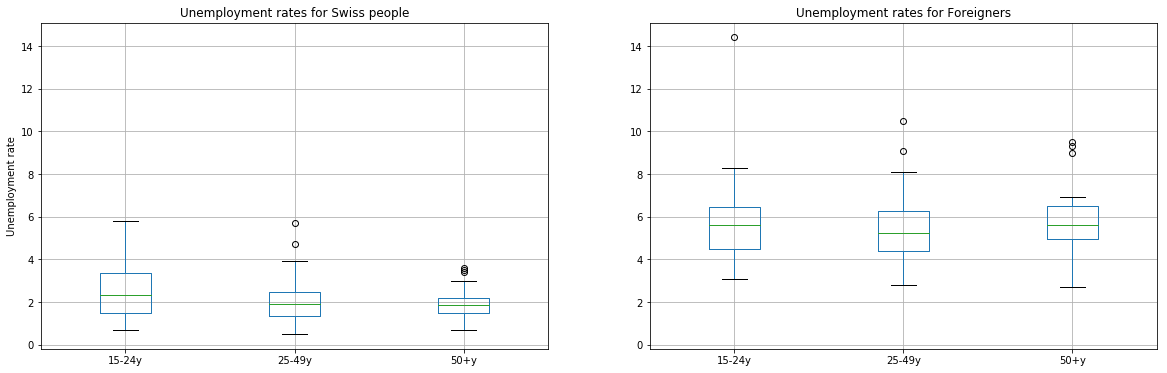

In [68]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharey = True)
fig.set_size_inches(20, 6)

df_mw[df_mw['nationality']=='Schweizer'].boxplot(column=['youth unemp quote', 
                                                         '25-49y unemp quote', 
                                                         '50+ unemp quote'],
                                                 ax=ax[0])
ax[0].set_title('Unemployment rates for Swiss people')

df_mw[df_mw['nationality'] == 'Ausländer'].boxplot(column=['youth unemp quote', 
                                                           '25-49y unemp quote', 
                                                           '50+ unemp quote'],
                                                   ax=ax[1])
ax[1].set_title('Unemployment rates for Foreigners')

ax[0].set_ylabel('Unemployment rate')
ax[0].set_xticklabels(['15-24y', '25-49y', '50+y'])
ax[1].set_xticklabels(['15-24y', '25-49y', '50+y'])

ax[1].yaxis.set_ticks_position('left')

plt.show()

Overall, we see a higher mean unemployment for foreigners and young age groups, in foreigner and Swiss population. While the Swiss population has a higher variance in young age groups, the foreign population has a similar variance in young and middle-aged population groups.

Next, we can show the difference in unemployment rates for each canton. The plot below will show foreigner and Swiss worklessness quotes for all age categories and all cantons, the cantons being sorted top to bottom starting with by their mean worklessness rates over all population groups.

In [69]:
df_mw['tot pop'] = np.round(df_mw['tot unemp'].values / (df_mw['tot unemp quote'].values/100)).astype(int)
df_mw.sort_values(by='canton',ascending=True).head()

,canton,nationality,tot unemp,tot unemp quote,youth unemp,youth unemp quote,50+ unemp,50+ unemp quote,25-49y unemp,25-49y unemp quote,tot pop
37,Aargau,Schweizer,6004,2.2,921,2.5,1988,2.1,3094,2.2,272909
36,Aargau,Ausländer,5479,6.2,605,5.8,1109,6.5,3764,6.2,88371
28,Appenzell Ausserrhoden,Ausländer,205,3.9,19,4.4,57,4.4,128,3.7,5256
29,Appenzell Ausserrhoden,Schweizer,352,1.4,55,1.4,141,1.5,155,1.3,25143
30,Appenzell Innerrhoden,Ausländer,45,3.9,5,8.2,14,5.1,24,3.1,1154


In [70]:
def f(df):
    q = np.divide(df['tot unemp'], df['tot pop']) # quote: for Swiss / Foreigners
    w = np.divide(df['tot pop'], sum(df['tot pop'])) # weight: fraction of population
    return np.dot(q,w)*100

df_cant_mean_unemp = pd.DataFrame(df_mw.groupby('canton').apply(f))
df_cant_mean_unemp.reset_index(inplace=True)
df_cant_mean_unemp.columns=('canton','unemp rate')

In [71]:
df_cant_mean_unemp = df_cant_mean_unemp.sort_values(by='unemp rate',ascending=True)

In [72]:
cantons_sorted_by_mean = df_cant_mean_unemp.values[:, 0]
cantons_sorted_by_mean

array(['Obwalden', 'Uri', 'Nidwalden', 'Appenzell Innerrhoden', 'Schwyz',
       'Graubünden', 'Appenzell Ausserrhoden', 'Luzern', 'Glarus', 'Zug',
       'Thurgau', 'St. Gallen', 'Bern', 'Freiburg', 'Solothurn',
       'Basel-Landschaft', 'Aargau', 'Schaffhausen', 'Tessin', 'Zürich',
       'Basel-Stadt', 'Wallis', 'Jura', 'Waadt', 'Genf', 'Neuenburg'], dtype=object)

In [73]:
# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(cantons_sorted_by_mean, range(len(cantons_sorted_by_mean))))

# Generate a rank column that will be used to sort the dataframe numerically
df_mw['canton_rank'] = df_mw['canton'].map(sorterIndex)

In [74]:
# using df_mw

# Swiss age categories
df_cat1_ch = df_mw[df_mw['nationality'] == 'Schweizer'].sort_values(by='canton_rank')['youth unemp quote']
df_cat2_ch = df_mw[df_mw['nationality'] == 'Schweizer'].sort_values(by='canton_rank')['25-49y unemp quote']
df_cat3_ch = df_mw[df_mw['nationality'] == 'Schweizer'].sort_values(by='canton_rank')['50+ unemp quote']

In [75]:
# foreigner age categories
df_cat1_for = df_mw[df_mw['nationality'] == 'Ausländer'].sort_values(by='canton_rank')['youth unemp quote']
df_cat2_for = df_mw[df_mw['nationality'] == 'Ausländer'].sort_values(by='canton_rank')['25-49y unemp quote']
df_cat3_for = df_mw[df_mw['nationality'] == 'Ausländer'].sort_values(by='canton_rank')['50+ unemp quote']

In [76]:
# remove column "Gesamt"
cantons_sorted_by_mean = cantons_sorted_by_mean[cantons_sorted_by_mean!="Gesamt"]

# inverse list to get descending (highest first)
#cantons_sorted_by_mean = cantons_sorted_by_mean[::-1]

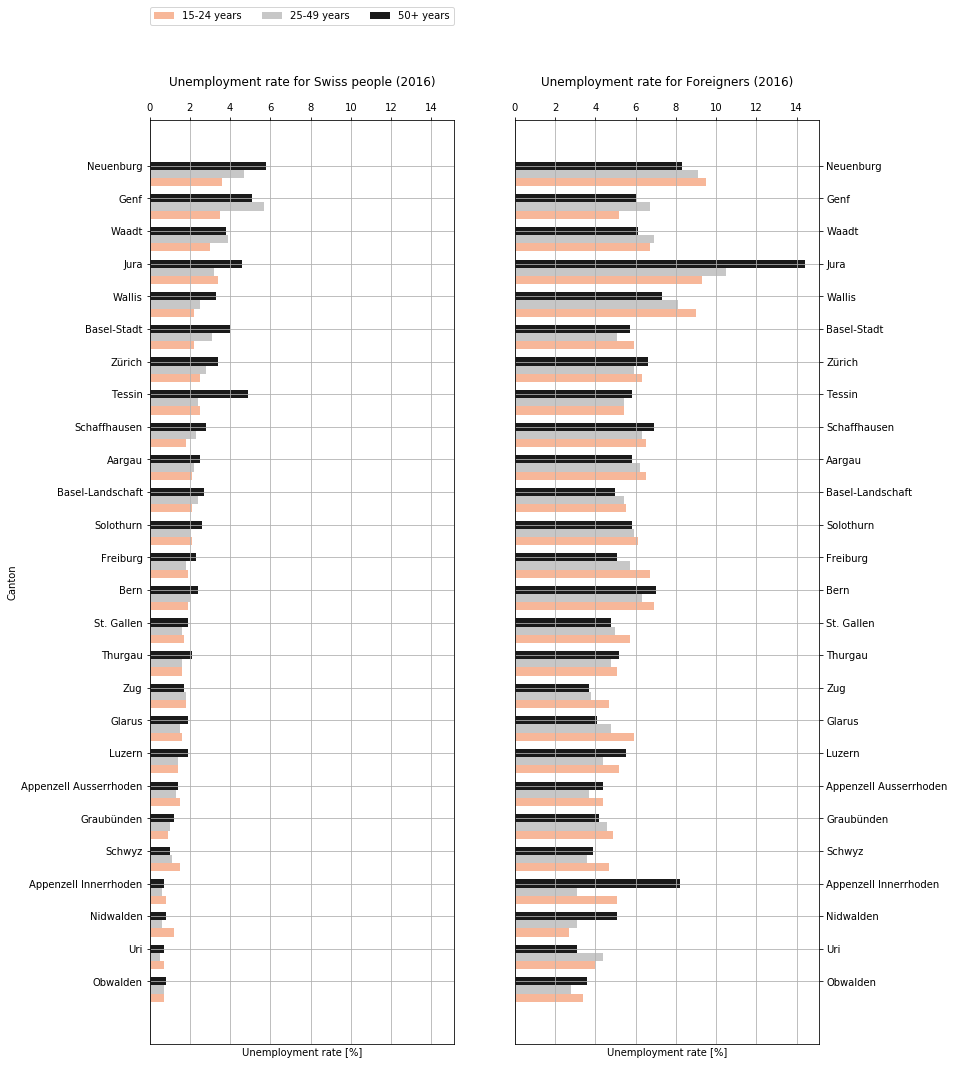

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_size_inches(12, 17)

# global parameters
color = cm.RdGy(np.linspace(0, 1, 4))
width = .25

# data
x = np.arange(len(df_cat1_ch))
y_ch = [df_cat3_ch, df_cat2_ch, df_cat1_ch]
y_for = [df_cat3_for, df_cat2_for, df_cat1_for]

# plot data
for i in range(-1,2):
    ax[0].barh(x+i*width, y_ch[i+1], width, align='center', tick_label=cantons_sorted_by_mean, color=color[i+2])
    ax[1].barh(x+i*width, y_for[i+1], width, align='center', tick_label=cantons_sorted_by_mean, color=color[i+2])
    
# legend
ax[0].legend(['15-24 years','25-49 years','50+ years'],bbox_to_anchor=(0., 1.02, 1., .102), loc=2,
           ncol=3, mode='expand', borderaxespad=0.)

# tick labels, position
ax[0].set_xlabel('Unemployment rate [%]')
ax[1].set_xlabel('Unemployment rate [%]')
ax[0].set_ylabel('Canton')

ax[0].set_yticklabels(cantons_sorted_by_mean)
ax[0].xaxis.set_ticks_position('top')
ax[1].xaxis.set_ticks_position('top')
ax[1].set_yticklabels(cantons_sorted_by_mean)
ax[1].yaxis.set_ticks_position('right')

# title
ax[0].set_title('Unemployment rate for Swiss people (2016)')
ax[1].set_title('Unemployment rate for Foreigners (2016)')
ax[0].title.set_position([.5, 1.03])
ax[1].title.set_position([.5, 1.03])

# grid
ax[0].grid()
ax[1].grid()

plt.show()

Again, we can visually confirm that unemployment rates are higher for young people in almost all cantons, with a less pronounced differece in the more rural cantons where unemployment rates are lower (Uri, Obwalden Apenzell Innerrhoden). Interestingly too, the variation in worklessness seems much stronger in the foreign population. The middle-age category quote has to be interpreted with some precaution however because it was interpolated.

# 4) Bonus: 

*BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

We can already see from the visualizations above that the French-speaking part of Switzerland has higher worklessness rates. To confirm this, we will calculate the mean worklessness rates in the cantons correponding to the language regions of Switzerland, similar as done before for foreigners / Swiss people. We will suppose that bilingual cantons belong to the region of the majority language group.

On the Amstat website, it is possible to add a field corresponding the the speaking region (it adds the speaking region which the canton belongs to): German-speaking Switzerland, Western Switzerland (French) and Tessin (Italian).

In [78]:
df = pd.read_excel('data/bonus.xlsx')
df.head()

,Sprachregion,Kanton,Monat,September 2017,September 2017.1,Gesamt,Gesamt.1
0,NaN,NaN,Metriken,Arbeitslosenquote,Registrierte Arbeitslose,Arbeitslosenquote,Registrierte Arbeitslose
1,Deutsche Schweiz,Zürich,NaN,3.3,27225,3.3,27225
2,Deutsche Schweiz,Bern,NaN,2.4,13658,2.4,13658
3,Deutsche Schweiz,Luzern,NaN,1.7,3885,1.7,3885
4,Deutsche Schweiz,Uri,NaN,0.6,112,0.6,112


In [79]:
# delete first row
df = df.drop([df.index[0], df.index[len(df)-1]]) 

# select interesting columns
df = df.drop(['Monat','September 2017','September 2017.1'],axis=1)

df.columns = ['language_region', 'canton', 'rate', 'registered']
df['registered'] = df['registered'].astype(int)
df['rate'] = df['rate'].astype(float)

df = df.reset_index(drop=True)
df.head()

,language_region,canton,rate,registered
0,Deutsche Schweiz,Zürich,3.3,27225
1,Deutsche Schweiz,Bern,2.4,13658
2,Deutsche Schweiz,Luzern,1.7,3885
3,Deutsche Schweiz,Uri,0.6,112
4,Deutsche Schweiz,Schwyz,1.7,1455


We will compute the number of active people in each canton ($N_{active} = \frac{rate}{N_{registered}}$).

Then we will compute the unemployement rate of the region as the number of registered jobseekers divided by the number of active people in the region.

In [80]:
df['canton_active_pop'] = df['registered'] / df['rate']

In [81]:
german_rate = df.loc[df.language_region == 'Deutsche Schweiz', 'registered'].sum() / df.loc[df.language_region == 'Deutsche Schweiz', 'canton_active_pop'].sum()
roman_rate = df.loc[df.language_region == 'Westschweiz und Tessin', 'registered'].sum() / df.loc[df.language_region == 'Westschweiz und Tessin', 'canton_active_pop'].sum()

In [82]:
print('Unemployement rates are {} for German Switzerland and {} for West Switzerland.'.format(german_rate.round(1), roman_rate.round(1)))

Unemployement rates are 2.6 for German Switzerland and 4.0 for West Switzerland.


We note that it is true that the rate of unemployement is higher in the French-speaking part of Switzerland than in the German-speaking part of Switzerland.